# Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet169, MobileNetV2, EfficientNetB0
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model


# Define the paths of the dataset directories and Labels

In [2]:
# Define the paths to the dataset directories
train_dir = 'C:/Guvi Projects/emotional/dataset/train'
test_dir = 'C:/Guvi Projects/emotional/dataset/test'

# Define the emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Define hyperparameters, Load and Preprocess Dataset

In [3]:
# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

# Load the dataset function
def load_dataset(directory):
    X = []
    y = []
    for label in emotion_labels:
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (48, 48))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            X.append(image_rgb)
            y.append(emotion_labels.index(label))
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess the data
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=len(emotion_labels))
y_test = to_categorical(y_test, num_classes=len(emotion_labels))

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 48, 48, 3)
print(f"Testing data shape: {X_test.shape}")    # Should be (num_samples, 48, 48, 3)

Training data shape: (28709, 48, 48, 3)
Testing data shape: (7178, 48, 48, 3)


# Plot Dataset Distribution

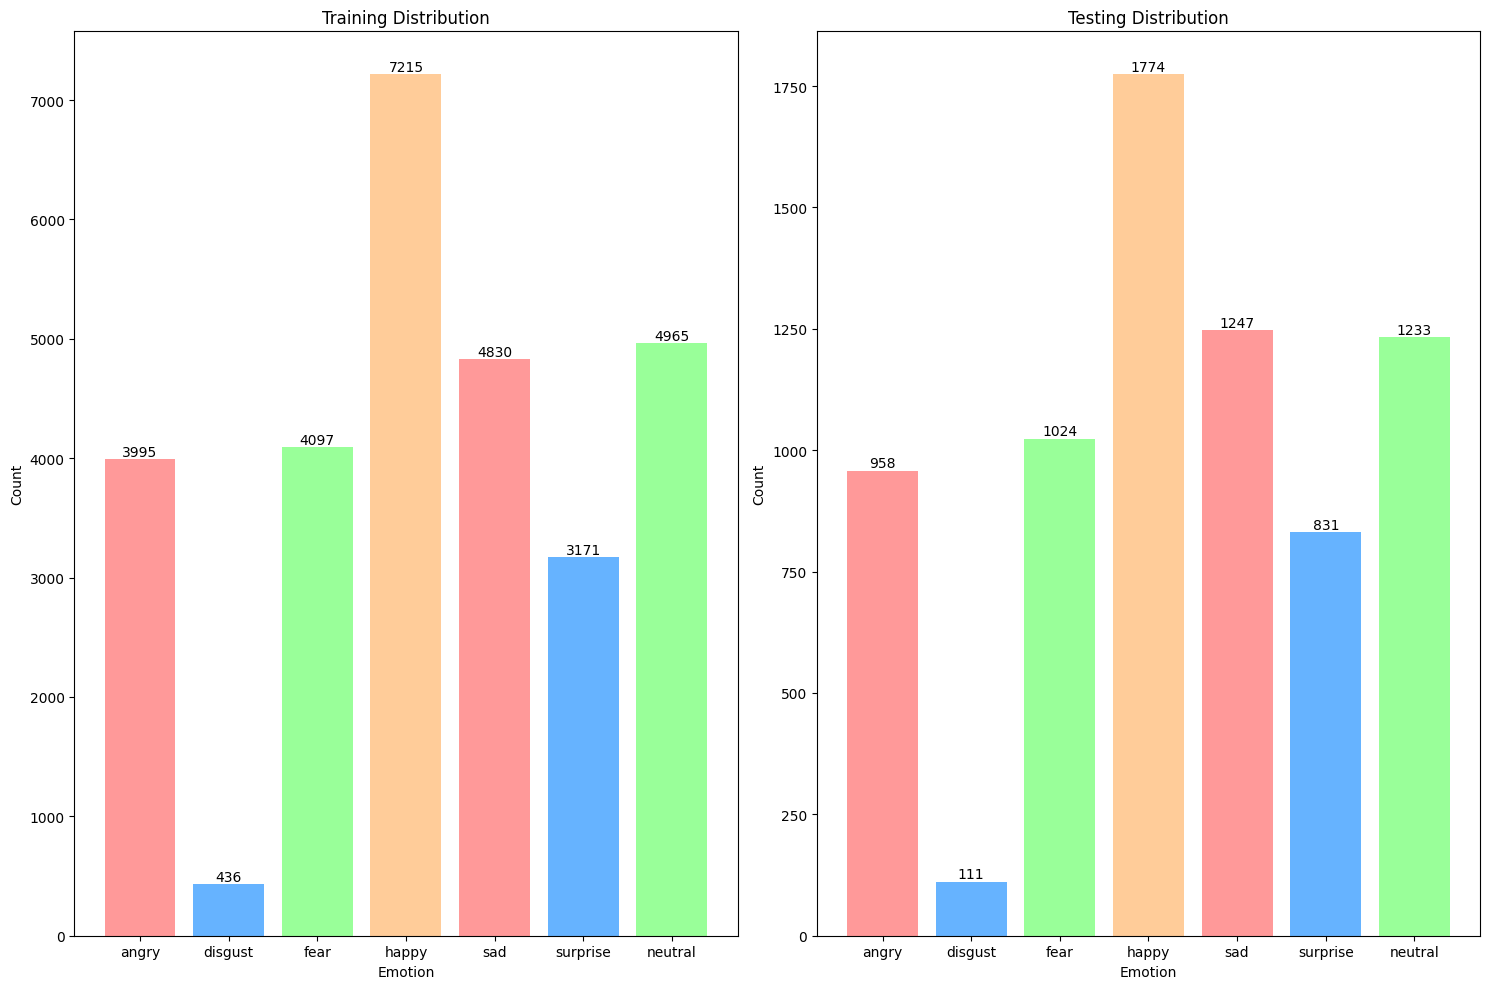

In [4]:
# Function to plot dataset distribution
def plot_dataset_distribution(ax, y, title):
    unique, counts = np.unique(np.argmax(y, axis=1), return_counts=True)    
    # Define colors for each emotion
    colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Custom color palette
    
    bars = ax.bar(emotion_labels, counts, color=colors)  # Set bar colors
    ax.set_title(title)
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))  # Create a subplot for training and testing distributions

# Plot training dataset distribution
plot_dataset_distribution(axs[0], y_train, 'Training Distribution')

# Plot testing dataset distribution
plot_dataset_distribution(axs[1], y_test, 'Testing Distribution')

# Adjust layout and save the figure
plt.tight_layout()

plt.savefig('C:/Guvi Projects/emotional/image/dataset_distribution.png')  # Save the figure

#plt.close()  # Close the plot to avoid displaying it immediately

# Data Augmentation

In [4]:
# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate

In [ ]:
# Learning Rate Scheduler
def create_lr_scheduler():
    return ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Function to train the model

In [ ]:
# Function to train the model with improved settings
def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
    lr_scheduler = create_lr_scheduler()  # Add learning rate scheduler

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping, lr_scheduler])
    
    return history

# Custom CNN Model

In [5]:
# Custom CNN Model with L2 Regularization and Batch Normalization
def create_custom_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Fine-tuning function for pre-trained models

In [6]:
# Fine-tuning function for pre-trained models
def fine_tune_model(model):
    for layer in model.layers:
        layer.trainable = True  # Unfreeze all layers for fine-tuning

# Densenet Model

In [8]:
# Transfer Learning Models Creation Functions
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

# Resnet Model 

In [9]:
def create_resnet_model(input_shape,num_classes):
     base_model = ResNet50(weights='imagenet', include_top=False,input_shape=input_shape)
     x = base_model.output
     x = GlobalAveragePooling2D()(x)
     x = Dense(512 ,activation='relu')(x)
     x = Dropout(0.5)(x)
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

# VGG Model

In [10]:
def create_vgg_model(input_shape,num_classes):
     base_model=VGG16(weights='imagenet' ,include_top=False,input_shape=input_shape)
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

# MobileNet Model

In [11]:
def create_mobilenet_model(input_shape,num_classes):
     base_model=MobileNetV2(weights='imagenet' ,include_top=False,input_shape=input_shape) 
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False 

     return model

# EfficientNet Model

In [12]:
def create_efficientnet_model(input_shape,num_classes):
      base_model=EfficientNetB0(weights='imagenet' ,include_top=False,input_shape=input_shape) 
      x=base_model.output 
      x=GlobalAveragePooling2D()(x) 
      x=Dense(512 ,activation='relu')(x) 
      x=Dropout(0.5)(x) 
      predictions=Dense(num_classes ,activation='softmax')(x)

      model=Model(inputs=base_model.input ,outputs=predictions)

      for layer in base_model.layers:
          layer.trainable=False 

      return model

# input shape and number of classes

In [7]:
# Define input shape and number of classes
input_shape = (48, 48, 3)
num_classes = len(emotion_labels)

# plot training history

In [8]:
# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Show the plot
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'C:/Guvi Projects/emotional/new/{model_name.lower()}_training_history.png')
    plt.show()

# DenseNet model

Training DenseNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 388s 684ms/step - accuracy: 0.2789 - loss: 1.7864 - val_accuracy: 0.3403 - val_loss: 1.6676 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.3281 - loss: 1.7590 - val_accuracy: 0.3410 - val_loss: 1.6650 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 218s 485ms/step - accuracy: 0.3285 - loss: 1.6793 - val_accuracy: 0.3600 - val_loss: 1.6126 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 103s 230ms/step - accuracy: 0.3750 - loss: 1.6894 - val_accuracy: 0.3611 - val_loss: 1.6121 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 313s 699ms/step - accuracy: 0.3303 - loss: 1.6691 - val_accuracy: 0.3775 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - accuracy: 0.2656 - loss: 1.6744 - val_accuracy: 0.3782 - val_loss: 1.6038 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 

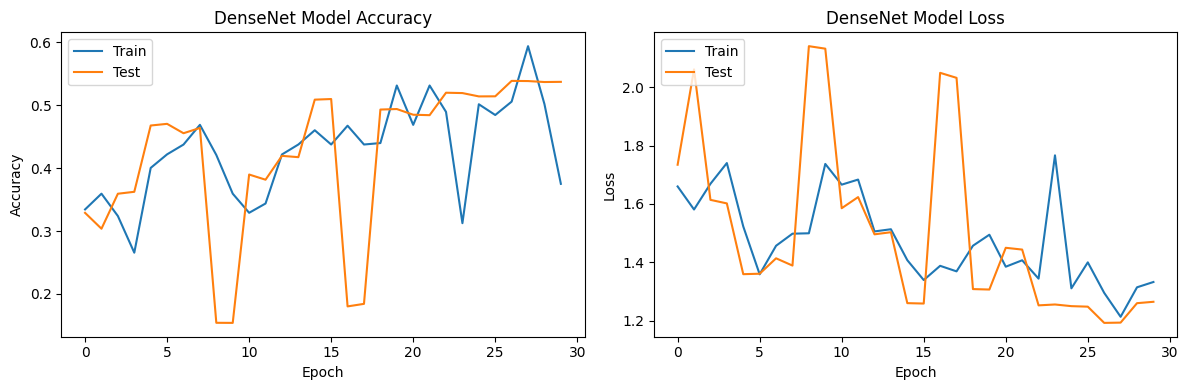

In [15]:
# Create and train DenseNet model
def train_densenet_model():
    densenet_model = create_densenet_model(input_shape, num_classes)
    print("Training DenseNet Model...")
    pretrained_history = train_model(densenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(densenet_model)
    pretrained_history_fine_tune = train_model(densenet_model, X_train, y_train, X_test, y_test)
    
    # Plot training history for DenseNet
    plot_training_history(pretrained_history_fine_tune, "DenseNet")

     # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/densenet_model.keras'  # Specify your desired file path
    densenet_model.save(model_save_path)
    
    return densenet_model, pretrained_history, pretrained_history_fine_tune

densenet_model ,densenet_history ,densenet_history_fine_tune=train_densenet_model()

# ResNet model

Training ResNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 290s 608ms/step - accuracy: 0.2259 - loss: 1.8883 - val_accuracy: 0.2471 - val_loss: 1.8150 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.2031 - loss: 1.8290 - val_accuracy: 0.2471 - val_loss: 1.8144 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 273s 607ms/step - accuracy: 0.2505 - loss: 1.8196 - val_accuracy: 0.2471 - val_loss: 1.8113 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.2969 - loss: 1.7432 - val_accuracy: 0.2471 - val_loss: 1.8115 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 216s 480ms/step - accuracy: 0.2517 - loss: 1.8205 - val_accuracy: 0.2471 - val_loss: 1.8098 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.2344 - loss: 1.8778 - val_accuracy: 0.2471 - val_loss: 1.8098 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 23

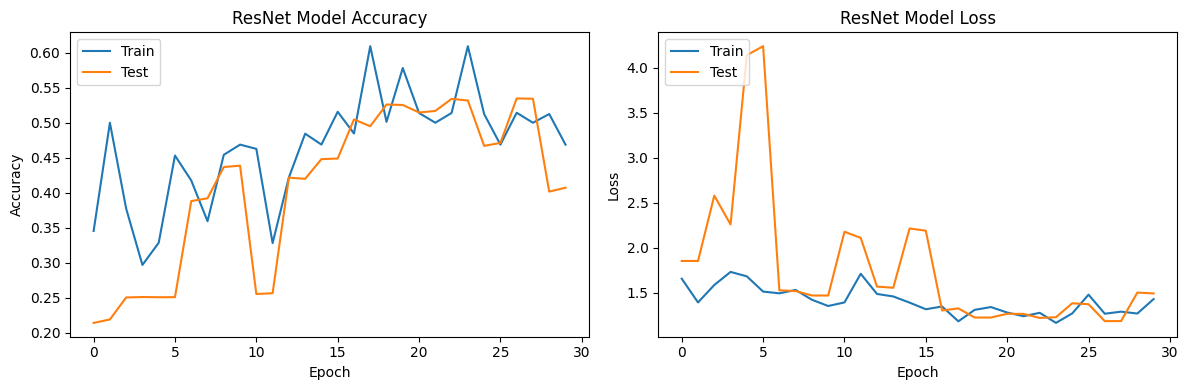

In [16]:
# Create and train ResNet model  
def train_resnet_model():
    resnet_model = create_resnet_model(input_shape, num_classes)
    print("Training ResNet Model...")
    pretrained_history = train_model(resnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(resnet_model)
    pretrained_history_fine_tune = train_model(resnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for ResNet
    plot_training_history(pretrained_history_fine_tune, "ResNet")

     # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/resnet_model.keras'  # Specify your desired file path
    resnet_model.save(model_save_path)

    return resnet_model, pretrained_history, pretrained_history_fine_tune

resnet_model ,resnet_history ,resnet_history_fine_tune=train_resnet_model()


# VGG model

Training VGG Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.2614 - loss: 1.8090 - val_accuracy: 0.3278 - val_loss: 1.6643 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 97s 215ms/step - accuracy: 0.2812 - loss: 1.7740 - val_accuracy: 0.3293 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.3183 - loss: 1.7001 - val_accuracy: 0.3541 - val_loss: 1.6376 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 203ms/step - accuracy: 0.2969 - loss: 1.7957 - val_accuracy: 0.3550 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.3248 - loss: 1.6871 - val_accuracy: 0.3587 - val_loss: 1.6179 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 90s 199ms/step - accuracy: 0.4219 - loss: 1.5589 - val_accuracy: 0.3571 - val_loss: 1.6198 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step -

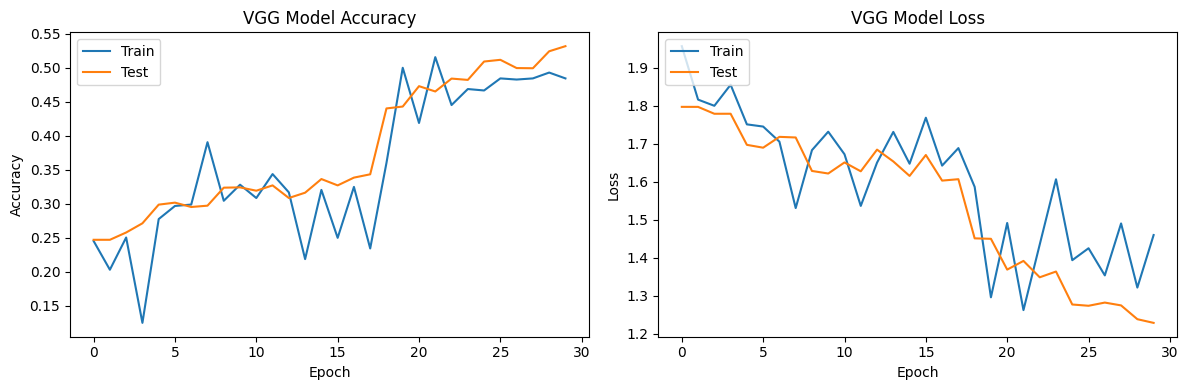

In [17]:
# Create and train VGG model
def train_vgg_model():
    vgg_model = create_vgg_model(input_shape, num_classes)
    print("Training VGG Model...")
    pretrained_history = train_model(vgg_model, X_train, y_train, X_test, y_test)
    fine_tune_model(vgg_model)
    pretrained_history_fine_tune = train_model(vgg_model, X_train, y_train, X_test, y_test)

    # Plot training history for VGG
    plot_training_history(pretrained_history_fine_tune, "VGG")

     # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/vgg_model.keras'  # Specify your desired file path
    vgg_model.save(model_save_path)

    return vgg_model, pretrained_history, pretrained_history_fine_tune

vgg_model ,vgg_history ,vgg_history_fine_tune=train_vgg_model()

# MobileNet model

Training MobileNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 108s 213ms/step - accuracy: 0.2662 - loss: 1.9080 - val_accuracy: 0.3320 - val_loss: 1.6739 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3125 - loss: 1.7145 - val_accuracy: 0.3282 - val_loss: 1.6749 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 266ms/step - accuracy: 0.3093 - loss: 1.7135 - val_accuracy: 0.3325 - val_loss: 1.6655 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.3281 - loss: 1.7492 - val_accuracy: 0.3314 - val_loss: 1.6672 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 212ms/step - accuracy: 0.3123 - loss: 1.6914 - val_accuracy: 0.3324 - val_loss: 1.6582 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.3438 - loss: 1.8353 - val_accuracy: 0.3320 - val_loss: 1.6597 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 81s

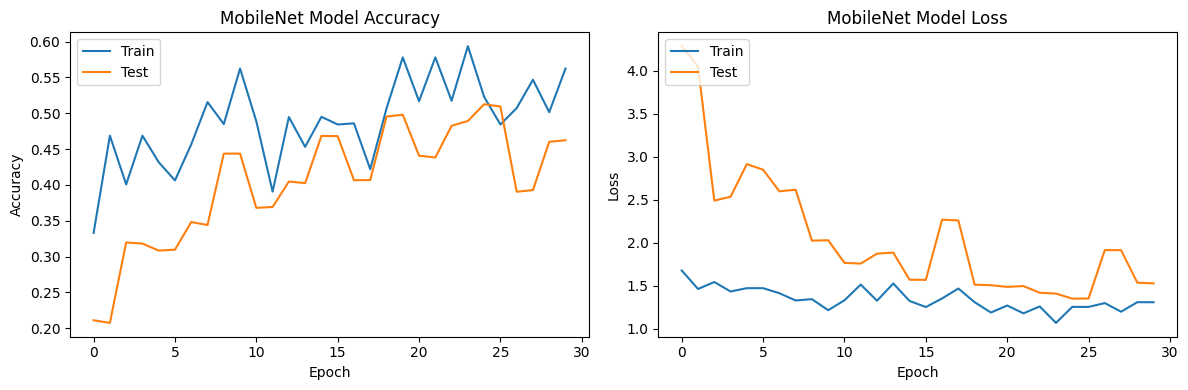

In [18]:
# Create and train MobileNet model
def train_mobilenet_model():
    mobilenet_model = create_mobilenet_model(input_shape, num_classes)
    print("Training MobileNet Model...")
    pretrained_history = train_model(mobilenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(mobilenet_model)
    pretrained_history_fine_tune = train_model(mobilenet_model, X_train, y_train, X_test, y_test)

    # Plot training history for MobileNet 
    plot_training_history(pretrained_history_fine_tune, "MobileNet")

     # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/mobilenet_model.keras'  # Specify your desired file path
    mobilenet_model.save(model_save_path)

    return mobilenet_model, pretrained_history, pretrained_history_fine_tune

mobilenet_model ,mobilenet_history ,mobilenet_history_fine_tune=train_mobilenet_model()

# EfficientNet model

Training EfficientNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 148s 270ms/step - accuracy: 0.2278 - loss: 1.8557 - val_accuracy: 0.2471 - val_loss: 1.8154 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.1719 - loss: 1.8493 - val_accuracy: 0.2471 - val_loss: 1.8153 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 108s 240ms/step - accuracy: 0.2545 - loss: 1.8226 - val_accuracy: 0.2471 - val_loss: 1.8152 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3438 - loss: 1.7634 - val_accuracy: 0.2471 - val_loss: 1.8149 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 105s 233ms/step - accuracy: 0.2514 - loss: 1.8166 - val_accuracy: 0.2471 - val_loss: 1.8139 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2500 - loss: 1.8402 - val_accuracy: 0.2471 - val_loss: 1.8137 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━

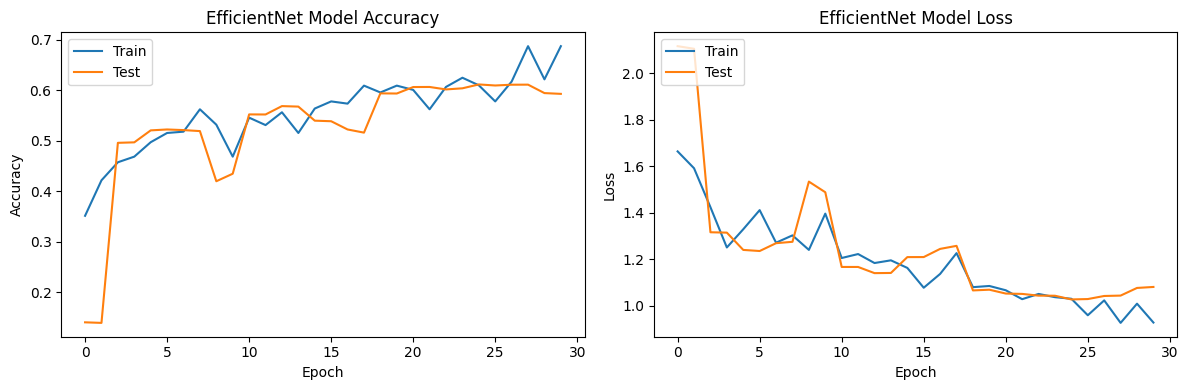

In [19]:
# Create and train EfficientNet model
def train_efficientnet_model():
    efficientnet_model = create_efficientnet_model(input_shape, num_classes)
    print("Training EfficientNet Model...")
    pretrained_history = train_model(efficientnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(efficientnet_model)
    pretrained_history_fine_tune = train_model(efficientnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for EfficientNet
    plot_training_history(pretrained_history_fine_tune,"EfficientNet")

     # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/efficientnet_model.keras'  # Specify your desired file path
    efficientnet_model.save(model_save_path)

    return efficientnet_model ,pretrained_history ,pretrained_history_fine_tune

    
efficientnet_model ,efficientnet_history ,efficientnet_history_fine_tune=train_efficientnet_model()

# Custom CNN model

Training Custom CNN Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 331ms/step - accuracy: 0.1877 - loss: 3.1605 - val_accuracy: 0.1885 - val_loss: 2.4754 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2500 - loss: 2.4888 - val_accuracy: 0.1991 - val_loss: 2.4610 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 132s 291ms/step - accuracy: 0.2269 - loss: 2.4801 - val_accuracy: 0.2729 - val_loss: 2.2749 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3750 - loss: 2.2352 - val_accuracy: 0.2704 - val_loss: 2.2776 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 134s 296ms/step - accuracy: 0.2753 - loss: 2.2529 - val_accuracy: 0.2602 - val_loss: 2.3815 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2188 - loss: 2.1232 - val_accuracy: 0.2644 - val_loss: 2.3604 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 159s

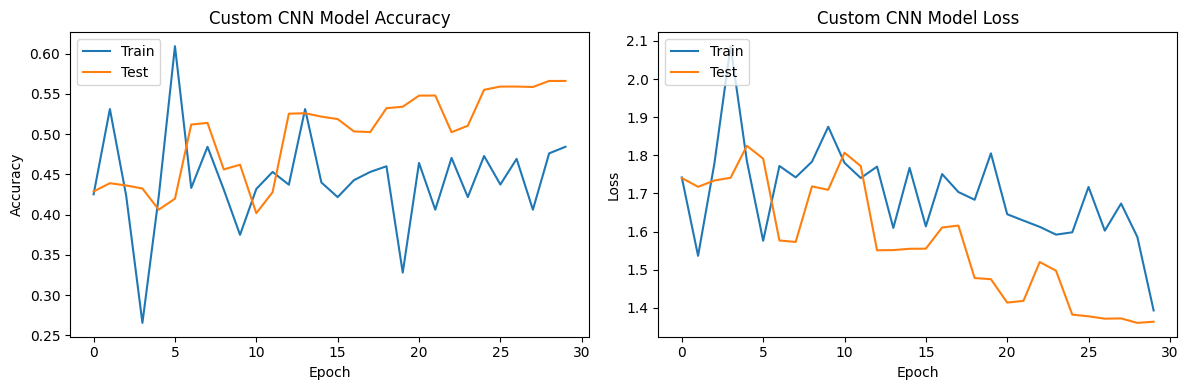

In [9]:
# Create and train Custom CNN model with fine-tuning
def train_custom_cnn_model():
    custom_cnn_model = create_custom_cnn_model(input_shape, num_classes)
    print("Training Custom CNN Model...")
    
    # Train the model initially
    pretrained_history = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)
    
    # Fine-tune the model
    fine_tune_model(custom_cnn_model)
    
    # Retrain the model after fine-tuning
    pretrained_history_fine_tune = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)

    # Plot training history for Custom CNN
    plot_training_history(pretrained_history_fine_tune, "Custom CNN")

    # Save the trained model
    model_save_path = 'C:/Guvi Projects/emotional/image/custom_cnn_model.keras'  # Specify your desired file path
    custom_cnn_model.save(model_save_path)

    return custom_cnn_model, pretrained_history, pretrained_history_fine_tune

# Train and fine-tune Custom CNN Model
custom_cnn_model, custom_cnn_history, custom_cnn_history_fine_tune = train_custom_cnn_model()

# evaluate performance metrics

In [11]:
# Function to evaluate performance metrics including ROC AUC score
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Ensure y_test_classes is correctly formatted
    y_test_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test 

    report = classification_report(y_test_classes, predicted_classes, zero_division=1)
    roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
    
    return loss, accuracy, report, roc_auc

# model file paths

In [12]:
# List of model file paths
model_paths = [
    r"C:/Guvi Projects/emotional/image/densenet_model.keras",
    r"C:/Guvi Projects/emotional/image/efficientnet_model.keras",
    r"C:/Guvi Projects/emotional/image/mobilenet_model.keras",
    r"C:/Guvi Projects/emotional/image/resnet_model.keras",
    r"C:/Guvi Projects/emotional/image/vgg_model.keras",
    r"C:/Guvi Projects/emotional/image/custom_cnn_model.keras"
]

In [13]:
# Evaluate all models and store results
results = {}

for model_path in model_paths:
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    
    print("Evaluating model...")
    loss, accuracy, report, roc_auc = evaluate_model(model, X_test, y_test)
    
    # Store results in a dictionary
    results[model_path] = {
        'loss': loss,
        'accuracy': accuracy,
        'classification_report': report,
        'roc_auc': roc_auc
    }
    
    print(f"Model: {model_path}")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(report)


Loading model from C:/Guvi Projects/emotional/image/densenet_model.keras...
Evaluating model...
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.4206 - loss: 1.3750
225/225 ━━━━━━━━━━━━━━━━━━━━ 77s 291ms/step
Model: C:/Guvi Projects/emotional/image/densenet_model.keras
Loss: 1.1930, Accuracy: 0.5386, ROC AUC: 0.8392
              precision    recall  f1-score   support

           0       0.44      0.36      0.39       958
           1       1.00      0.00      0.00       111
           2       0.29      0.06      0.11      1024
           3       0.72      0.87      0.79      1774
           4       0.41      0.39      0.40      1247
           5       0.61      0.77      0.68       831
           6       0.44      0.64      0.52      1233

    accuracy                           0.54      7178
   macro avg       0.56      0.44      0.41      7178
weighted avg       0.51      0.54      0.50      7178

Loading model from C:/Guvi Projects/emotional/image/efficientnet_model.keras

# best performing model based on accuracy

In [14]:
# Determine best performing model based on accuracy
best_model_path = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_performance = results[best_model_path]

print("\nBest Performing Model:")
print(f"Model Path: {best_model_path}")
print(f"Loss: {best_performance['loss']:.4f}, Accuracy: {best_performance['accuracy']:.4f}, ROC AUC: {best_performance['roc_auc']:.4f}")


Best Performing Model:
Model Path: C:/Guvi Projects/emotional/image/custom_cnn_model.keras
Loss: 1.3605, Accuracy: 0.5662, ROC AUC: 0.8649
